In [2]:
#from pyspark.sql import SparkSession

# Initialize a Spark session with explicit master and configurations
#spark = (
    #SparkSession.builder
    #.master("spark://10.100.157.150:7077")  # Master URL with Spark port
    #.appName("DATAFRAME Test 5")  # Application name
    #.config("spark.driver.host", "10.100.157.150")  # Driver host (IP only, no port)
    #.config("spark.driver.bindAddress", "10.100.157.150")  # Bind address for the driver
    #.config("spark.executor.cores", "2")  # Number of cores for each executor
    #.config("spark.executor.memory", "2g")  # Memory allocated per executor
    #.config("spark.executor.instances", "2")  # Number of executor instances
    #.getOrCreate()
#)

# Create a simple list of tuples
#data = [("Alice", 34), ("Bob", 45), ("Catherine", 29)]

# Define the schema (column names)
#columns = ["Name", "Age"]

# Create a DataFrame
#df = spark.createDataFrame(data, columns)

# Show the DataFrame
#df.show()

# Perform a simple operation (e.g., filtering)
#df_filtered = df.filter(df.Age > 30)

# Show the filtered DataFrame
#df_filtered.show()

# Stop the Spark session
#spark.stop()


In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import os
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [4]:
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\gfs\\fiery-odyssey-443218-b3-9006d193d677.json"

In [4]:
from pyspark.sql import SparkSession

# Initialize Spark session with GCS configurations
spark = SparkSession.builder \
    .appName("Test2 - only protiva v2") \
    .master("spark://192.168.142.181:7077") \
    .config("spark.driver.host", "192.168.142.181") \
    .config("spark.driver.bindAddress", "192.168.142.181")\
    .config("spark.executor.cores", "1")\
    .config("spark.executor.memory", "1g")\
    .config("spark.executor.instances", "3")\
    .config("spark.dynamicAllocation.enabled", "true")\
    .config("spark.dynamicAllocation.minExecutors", "3")\
    .config("spark.dynamicAllocation.maxExecutors", "6")\
    .getOrCreate()





In [6]:
import pandas as pd
pandas_df = pd.read_csv("C:/Users/user/Downloads/Live.csv")

In [8]:
df = spark.createDataFrame(pandas_df)

In [10]:
df.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|Column1|Column2|Column3|Column4|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|    NaN|    NaN|    NaN|    NaN|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|    NaN|    NaN|    NaN|    NaN|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      

In [12]:
X,_=make_blobs(n_samples=300,centers=4,cluster_std=0.6,random_state=42)
data = spark.createDataFrame([(float(x[0]), float(x[1])) for x in X], ["x", "y"])

In [14]:
vector_assembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
data = vector_assembler.transform(data)


In [16]:
k_values=range(2,11)

In [18]:
inertia=[]

In [20]:
for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(data)
    # WCSS is called "training cost" in PySpark's KMeans
    inertia.append(model.summary.trainingCost)

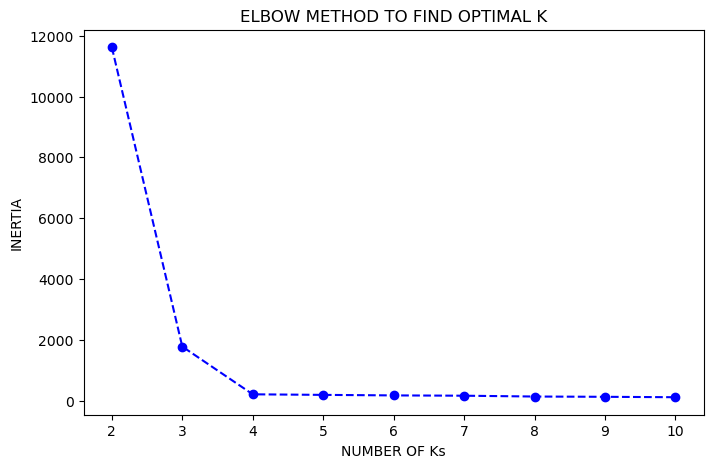

In [22]:
plt.figure(figsize=(8,5))
plt.plot(k_values,inertia,marker='o',linestyle='--',color='b')
plt.title('ELBOW METHOD TO FIND OPTIMAL K')
plt.xlabel('NUMBER OF Ks')
plt.ylabel('INERTIA')
plt.xticks(k_values)
plt.show()


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

In [24]:
# Show the first few rows of the data (EDA step)
df.show(5)

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|Column1|Column2|Column3|Column4|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|    NaN|    NaN|    NaN|    NaN|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|    NaN|    NaN|    NaN|    NaN|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      

In [25]:
# Drop unnecessary columns
df = df.drop('Column1', 'Column2', 'Column3', 'Column4')


In [26]:
from pyspark.sql import functions as F

# Check for missing values
missing_values = df.select([F.sum(df[col].isNull().cast("int")).alias(col) for col in df.columns])
missing_values.show()

+---------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+---------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|        0|          0|               0|            0|           0|         0|        0|        0|       0|        0|       0|         0|
+---------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+



In [27]:
# EDA - Check data types and schema
df.printSchema()

root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_shares: long (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- num_loves: long (nullable = true)
 |-- num_wows: long (nullable = true)
 |-- num_hahas: long (nullable = true)
 |-- num_sads: long (nullable = true)
 |-- num_angrys: long (nullable = true)



In [28]:
# EDA - Summary statistics
df.describe().show()

+-------+--------------------+-----------+----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|summary|           status_id|status_type|status_published|     num_reactions|     num_comments|        num_shares|        num_likes|         num_loves|          num_wows|         num_hahas|           num_sads|         num_angrys|
+-------+--------------------+-----------+----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|  count|                7050|       7050|            7050|              7050|             7050|              7050|             7050|              7050|              7050|              7050|               7050|               7050|
|   mean|                NULL|       NULL|            NULL|230.1171631205673

In [29]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
df_pandas = df.toPandas()


In [30]:
# Label encode the 'status_type' column using StringIndexer
indexer = StringIndexer(inputCol="status_type", outputCol="label")
df = indexer.fit(df).transform(df)

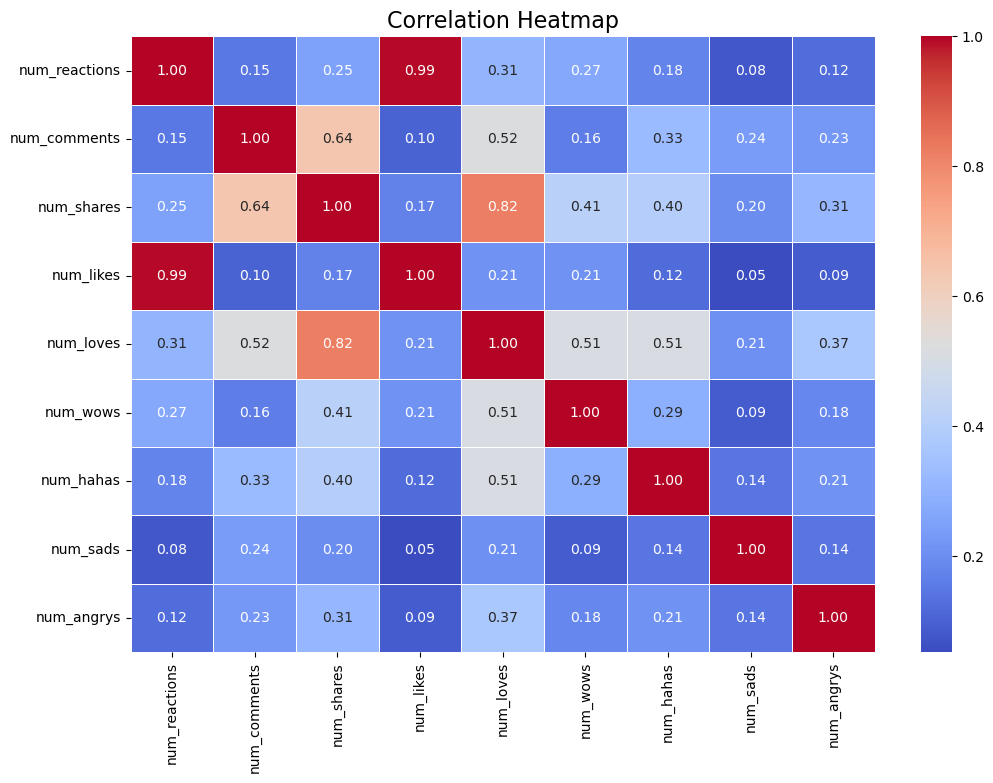

In [31]:
# Filter only numeric columns for correlation heatmap
numeric_df = df_pandas.select_dtypes(include=[np.number])

# 1. Correlation Heatmap (only numerical columns)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

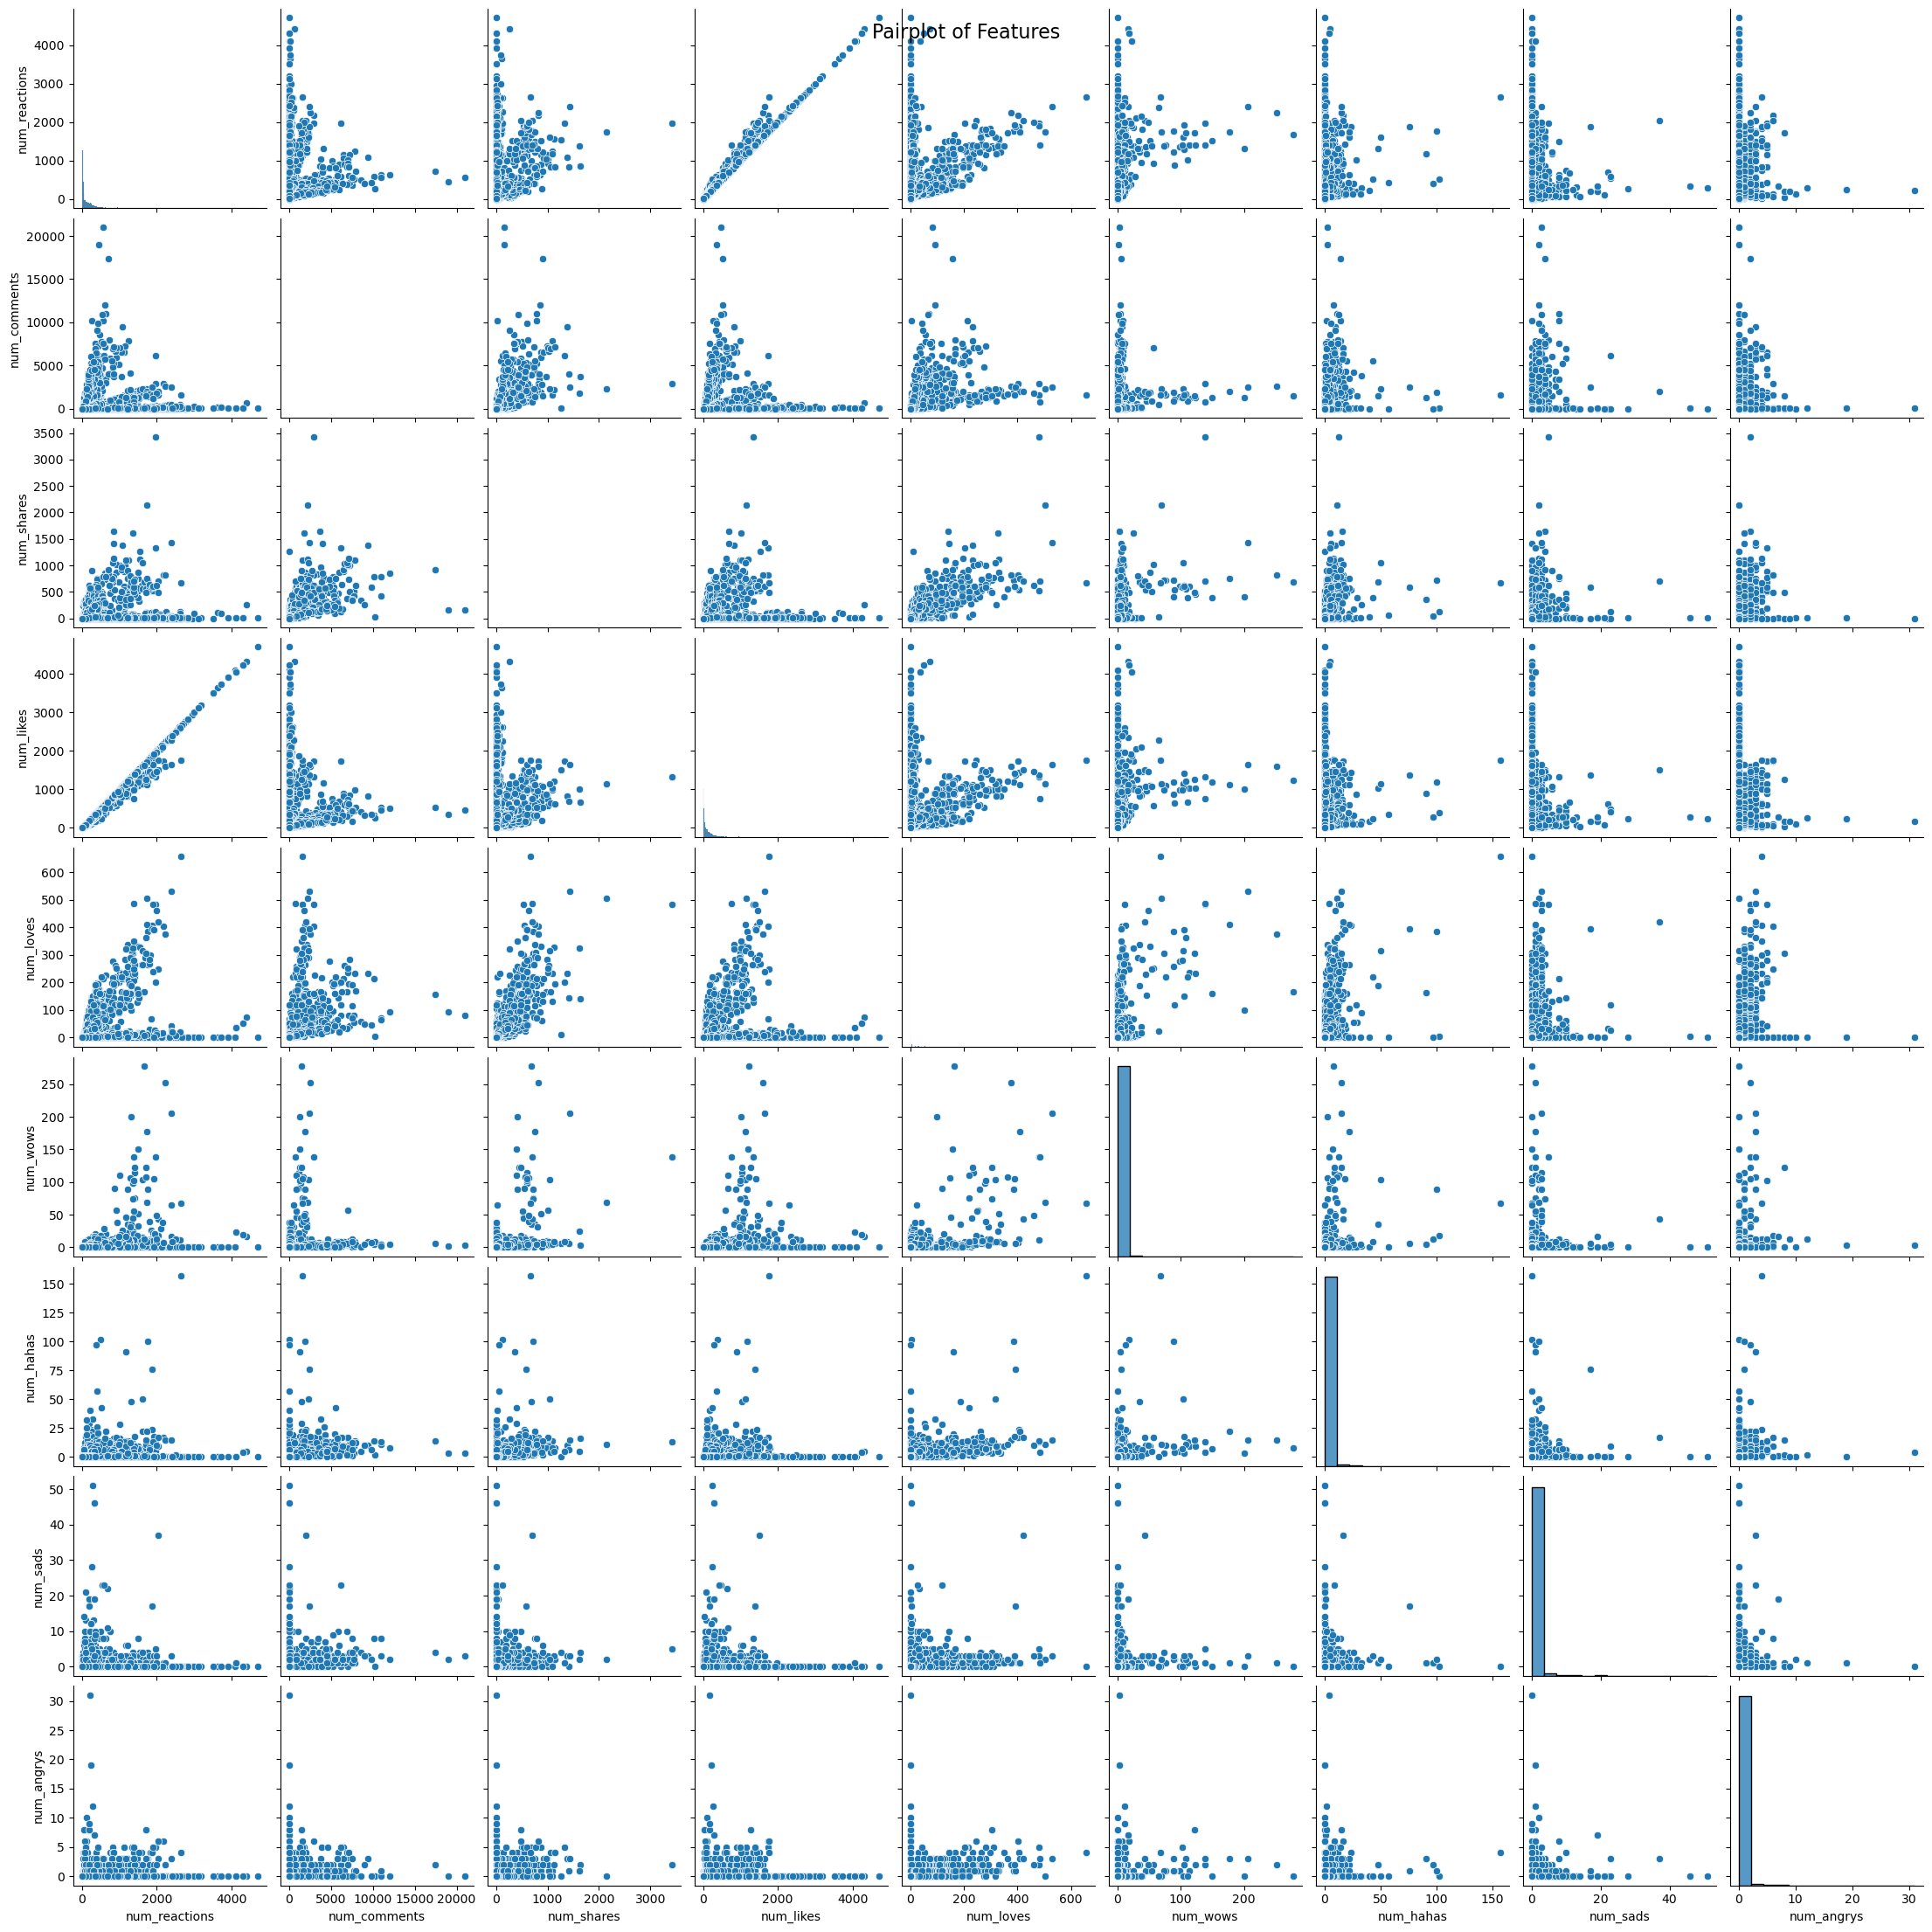

In [32]:
# 2. Pairplot (scatterplot matrix) to visualize relationships between numerical features
sns.pairplot(df_pandas)
plt.suptitle('Pairplot of Features', fontsize=16)
plt.show()



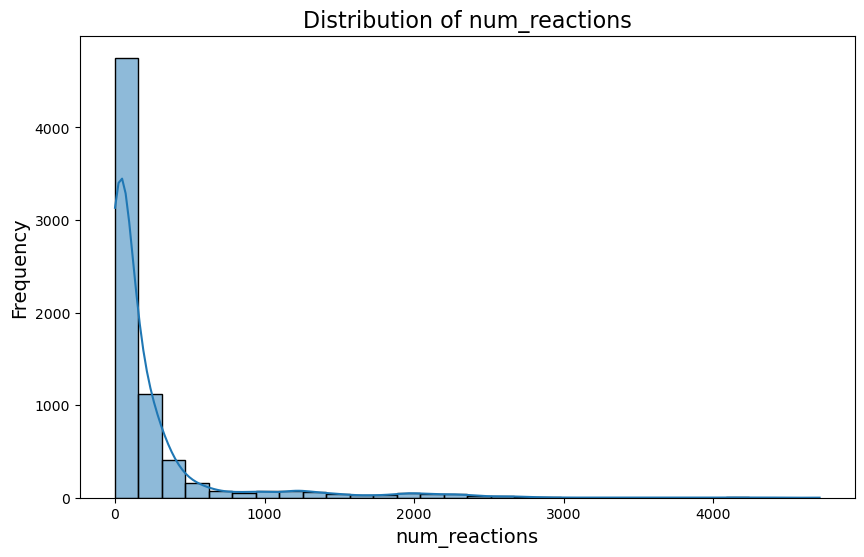

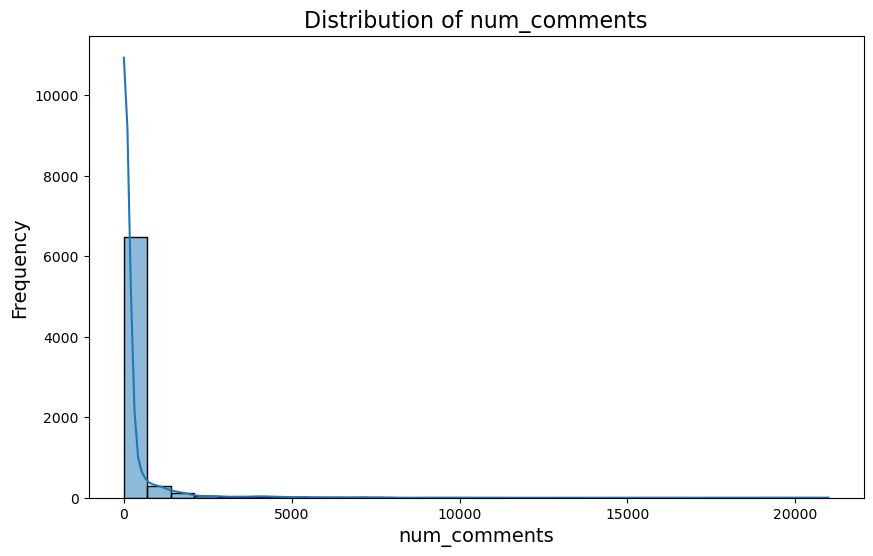

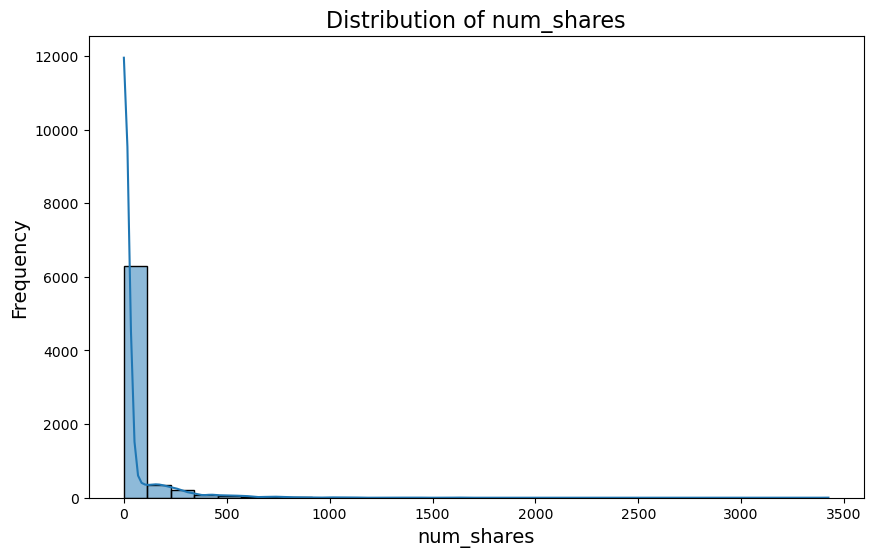

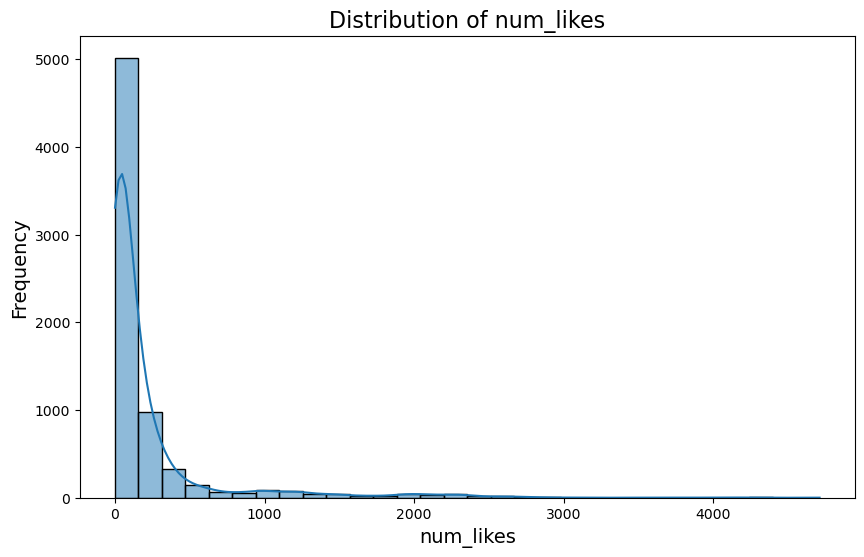

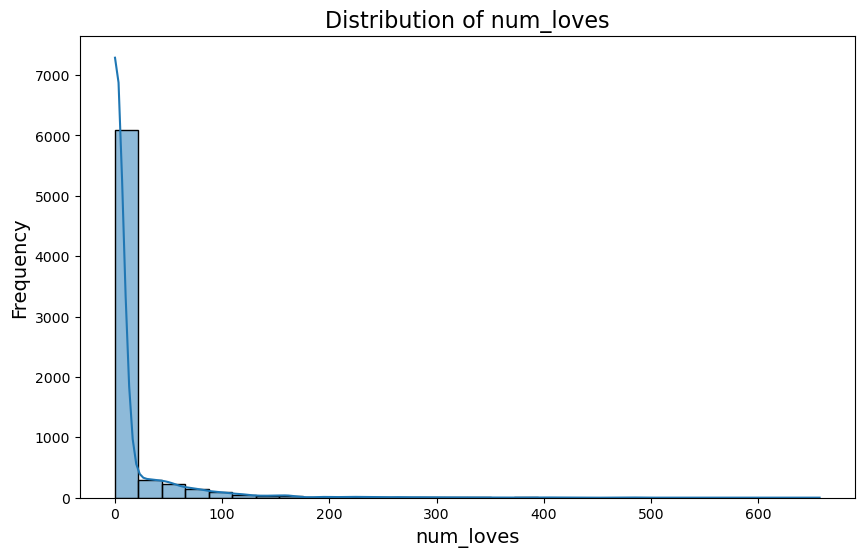

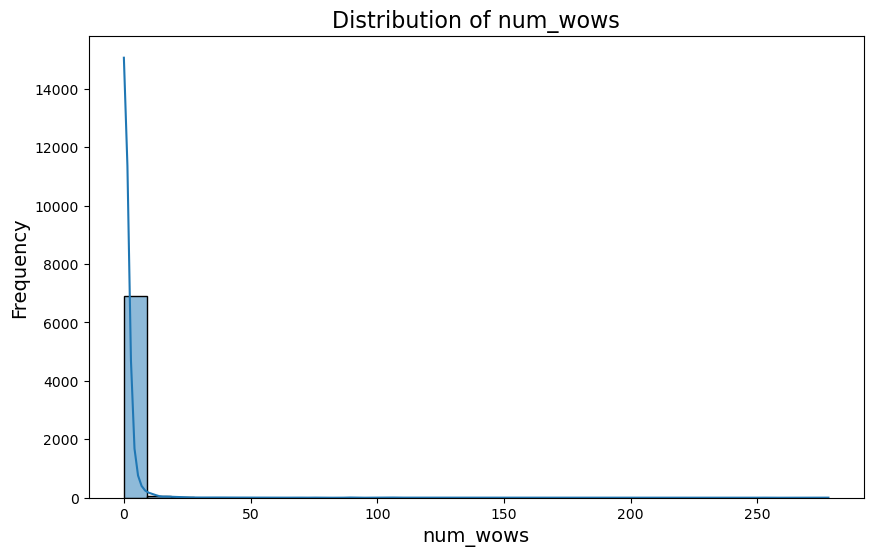

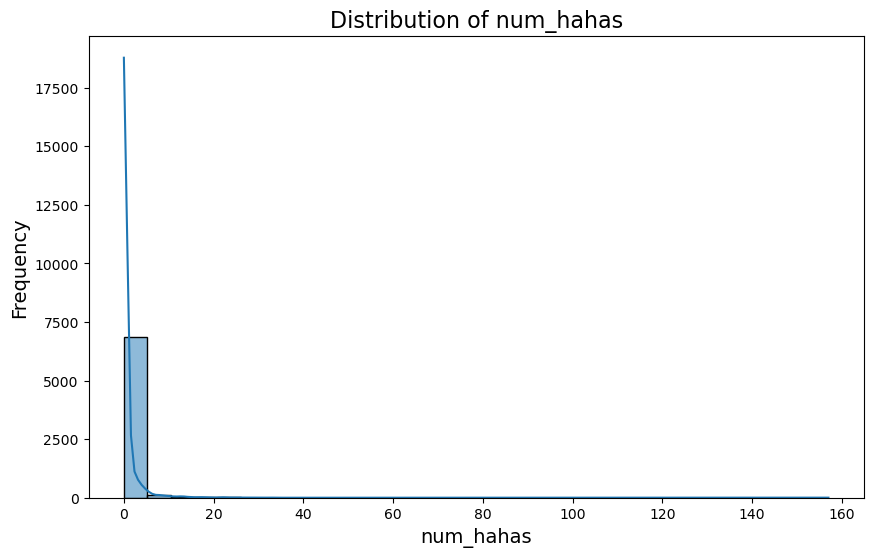

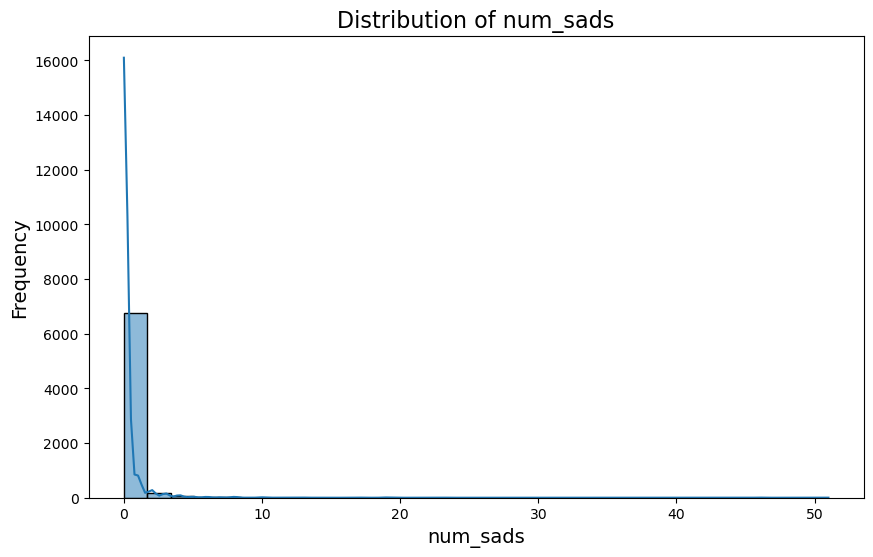

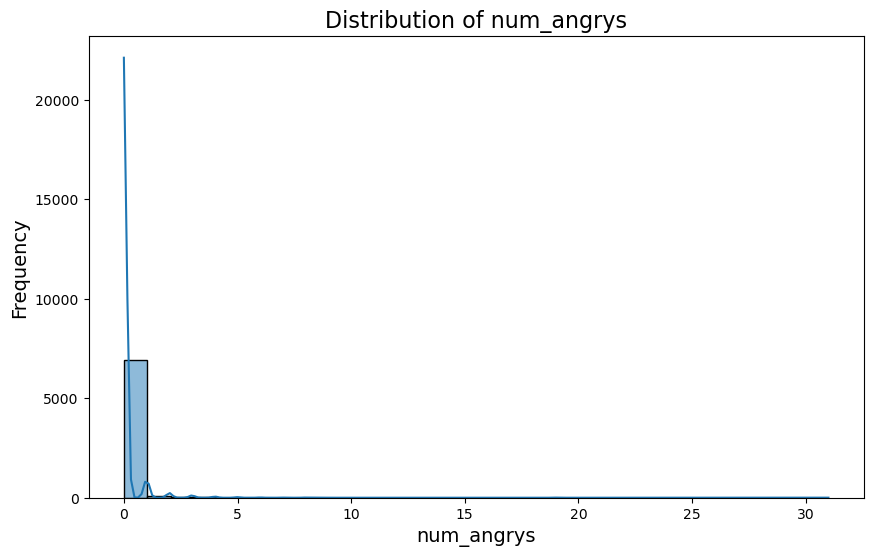

In [33]:
# 3. Distribution plots (histograms) for each feature
numerical_cols = df_pandas.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pandas[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.show()

In [34]:
# 1. Index categorical columns (status_id, status_published) if they are of type 'string'
indexer_status_id = StringIndexer(inputCol="status_id", outputCol="status_id_index")
indexer_status_published = StringIndexer(inputCol="status_published", outputCol="status_published_index")

# 2. Assemble the features into a vector (exclude the original string columns and the label)
assembler = VectorAssembler(inputCols=[col for col in df.columns if col not in ['status_type', 'status_id', 'status_published', 'label']],
                            outputCol="features")

# 3. Apply the transformations using a pipeline
pipeline = Pipeline(stages=[indexer_status_id, indexer_status_published, assembler])
df = pipeline.fit(df).transform(df)

In [35]:
# Apply PCA to reduce dimensions before clustering
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df)
df_pca = pca_model.transform(df)


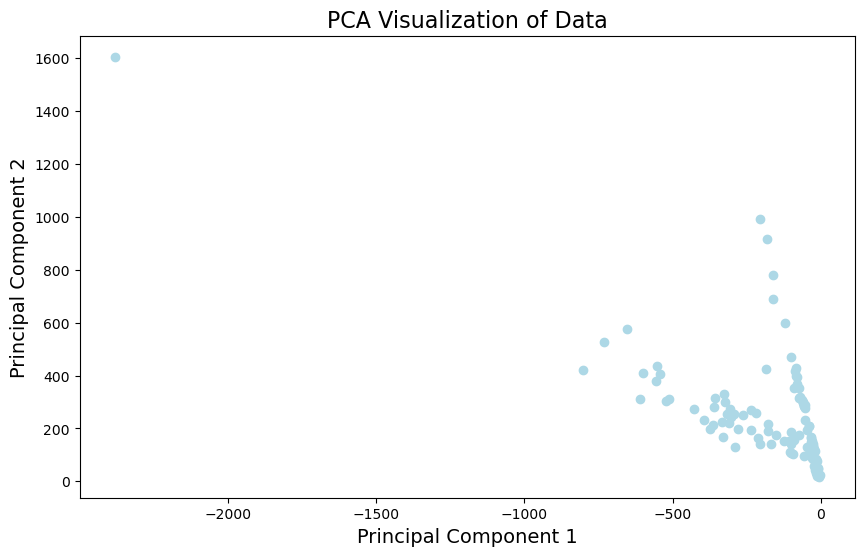

In [36]:

pca_result = df_pca.select("pca_features").take(100)

# Convert the PCA results to a NumPy array for plotting
pca_result = np.array([row['pca_features'] for row in pca_result])

# Plot the PCA result (EDA visualization)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='lightblue', marker='o')
plt.title('PCA Visualization of Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.show()

In [37]:
# KMeans with Elbow Method (Find optimal k)
cs = []
for i in range(2, 11):
    kmeans = KMeans().setK(i).setSeed(0)
    model = kmeans.fit(df)
    cs.append(model.summary.trainingCost)


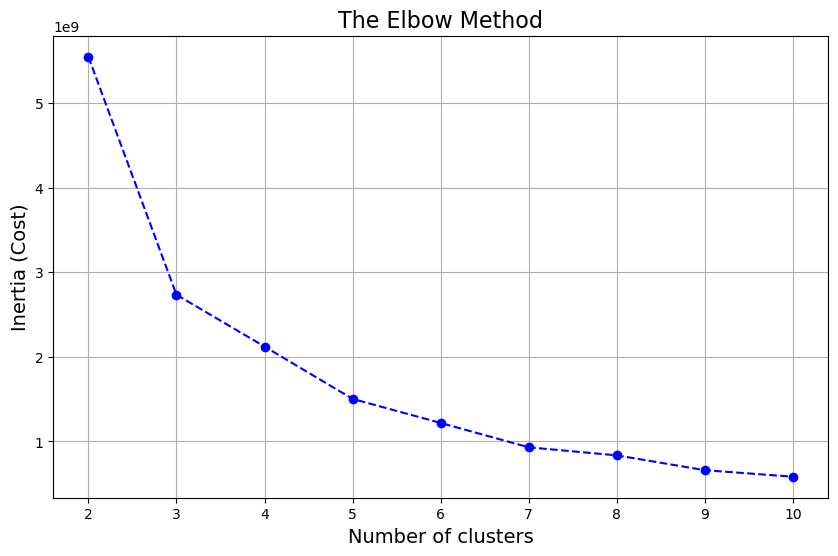

In [38]:
# Plot the Elbow curve (EDA visualization)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), cs, marker='o', color='b', linestyle='--')
plt.title('The Elbow Method', fontsize=16)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Inertia (Cost)', fontsize=14)
plt.grid(True)
plt.show()


In [39]:
# Perform KMeans clustering for different cluster values (2, 3, 4)

# KMeans for 2 clusters
kmeans_2 = KMeans().setK(2).setSeed(0)
model_2 = kmeans_2.fit(df)
predictions_2 = model_2.transform(df)

# Evaluate performance for 2 clusters
evaluator = ClusteringEvaluator()
silhouette_2 = evaluator.evaluate(predictions_2)
print(f"Silhouette score for 2 clusters: {silhouette_2}")# KMeans for 3 clusters
kmeans_3 = KMeans().setK(3).setSeed(0)
model_3 = kmeans_3.fit(df)
predictions_3 = model_3.transform(df)

# Evaluate performance for 3 clusters
silhouette_3 = evaluator.evaluate(predictions_3)
print(f"Silhouette score for 3 clusters: {silhouette_3}")

# KMeans for 4 clusters
kmeans_4 = KMeans().setK(4).setSeed(0)
model_4 = kmeans_4.fit(df)
predictions_4 = model_4.transform(df)

# Evaluate performance for 4 clusters
silhouette_4 = evaluator.evaluate(predictions_4)
print(f"Silhouette score for 4 clusters: {silhouette_4}")

# KMeans for 5 clusters
kmeans_5 = KMeans().setK(5).setSeed(0)
model_5 = kmeans_5.fit(df)
predictions_5 = model_5.transform(df)

# Evaluate performance for 4 clusters
silhouette_5 = evaluator.evaluate(predictions_5)
print(f"Silhouette score for 5 clusters: {silhouette_5}")

# KMeans for 6 clusters
kmeans_6 = KMeans().setK(6).setSeed(0)
model_6 = kmeans_6.fit(df)
predictions_6 = model_6.transform(df)

# Evaluate performance for 4 clusters
silhouette_6 = evaluator.evaluate(predictions_6)
print(f"Silhouette score for 6 clusters: {silhouette_6}")

# KMeans for 7 clusters
kmeans_7 = KMeans().setK(7).setSeed(0)
model_7 = kmeans_7.fit(df)
predictions_7 = model_7.transform(df)

# Evaluate performance for 4 clusters
silhouette_7 = evaluator.evaluate(predictions_7)
print(f"Silhouette score for 7 clusters: {silhouette_7}")

Silhouette score for 2 clusters: 0.8805658693771703
Silhouette score for 3 clusters: 0.9052039366452357
Silhouette score for 4 clusters: 0.9110734977263546
Silhouette score for 5 clusters: 0.8892991103956887
Silhouette score for 6 clusters: 0.8657989260420018
Silhouette score for 7 clusters: 0.8707079527356436


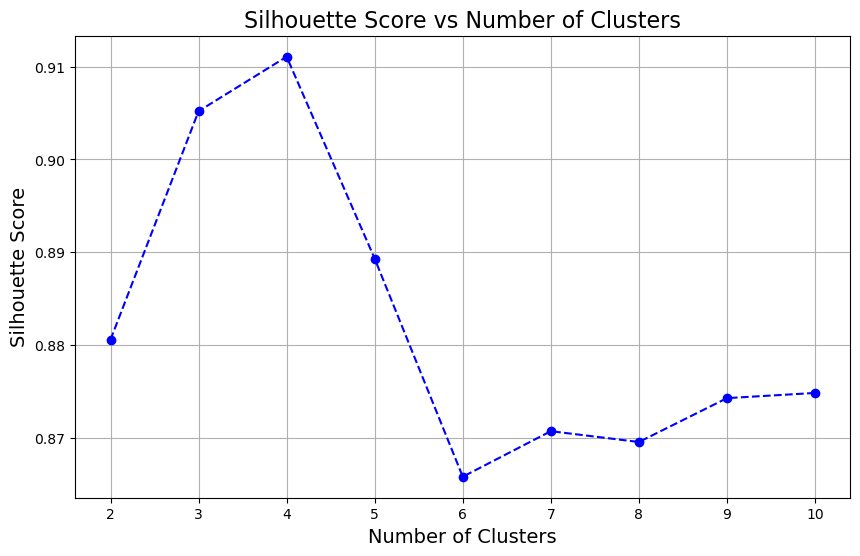

In [40]:
evaluator = ClusteringEvaluator()
silhouette_scores=[]
for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(0)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)


# Plot the Silhouette scores with respect to the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='b', linestyle='--')
plt.title('Silhouette Score vs Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True)
plt.show()


In [41]:
spark.stop()